<a href="https://colab.research.google.com/github/1000century/ml/blob/main/Algorithms/250205_%EC%8A%A4%ED%8C%8C%EA%B2%8C%ED%8B%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

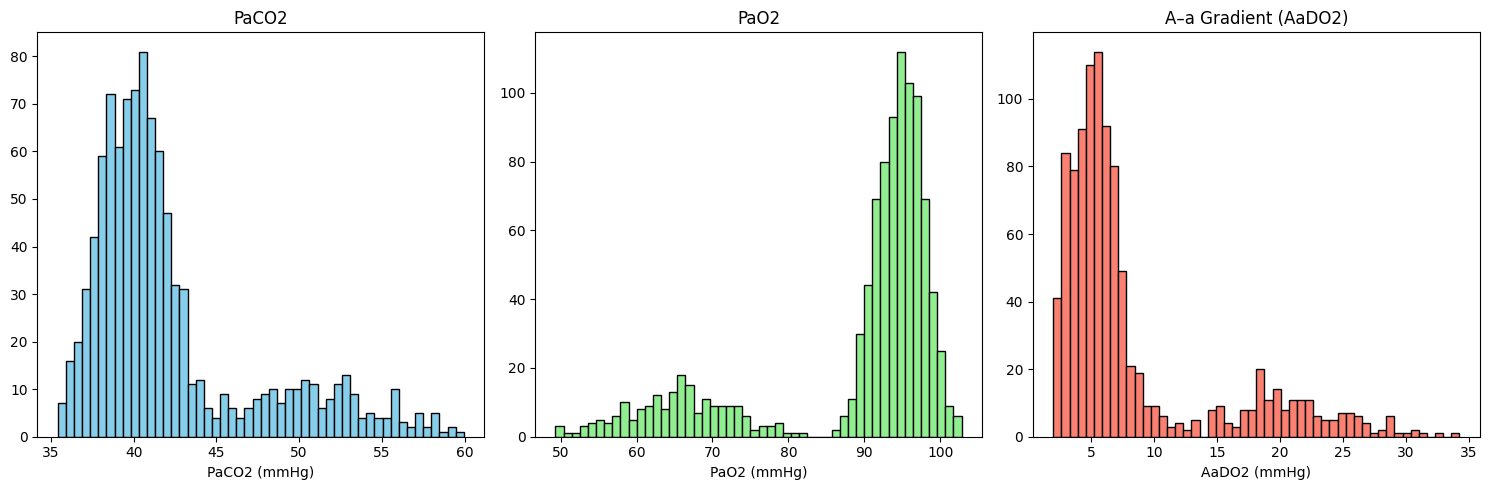

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# =============================================================================
# 도움 함수: truncated normal 샘플 생성
def get_truncated_normal(mean, sd, low, upp, size):
  a, b = (low - mean) / sd, (upp - mean) / sd
  return truncnorm(a, b, loc=mean, scale=sd).rvs(size)

# =============================================================================
# 설정 값
np.random.seed(42)  # 재현성을 위한 시드 설정
n_samples = 1000  # 전체 데이터 샘플 수

# 전체 인구의 80%는 정상군, 20%는 환자군으로 가정
n_healthy = int(n_samples * 0.8)
n_patients = n_samples - n_healthy

# 나이 생성 (20~80세 사이 랜덤 생성; 전체 샘플에 대해)
ages = np.random.randint(20, 81, size=n_samples)
# 각 집단에 대해 나이를 나눠줍니다.
ages_healthy = ages[:n_healthy]
ages_patients = ages[n_healthy:]

# =============================================================================
# 1. PaCO2 생성
# 정상군: PaCO2 평균 40, sd 2, 범위 [35, 45]
PaCO2_healthy = get_truncated_normal(mean=40, sd=2, low=35, upp=45, size=n_healthy)
# 환자군: PaCO2 평균 50, sd 5, 범위 [45, 60]
PaCO2_patients = get_truncated_normal(mean=50, sd=5, low=45, upp=60, size=n_patients)

# =============================================================================
# 2. 폐포 산소압 (PAO2) 계산: PAO2 = 150 - 1.25 * PaCO2
PAO2_healthy = 150 - 1.25 * PaCO2_healthy
PAO2_patients = 150 - 1.25 * PaCO2_patients

# =============================================================================
# 3. AaDO2 (A-a gradient) 생성
# 정상군: AaDO2 평균 5 mmHg, sd 2, 범위 [2, 12]
AaDO2_healthy = get_truncated_normal(mean=5, sd=2, low=2, upp=12, size=n_healthy)
# 환자군: AaDO2 평균 20 mmHg, sd 5, 범위 [10, 40]
AaDO2_patients = get_truncated_normal(mean=20, sd=5, low=10, upp=40, size=n_patients)

# =============================================================================
# 4. PaO2 계산: PaO2 = PAO2 - AaDO2
PaO2_healthy = PAO2_healthy - AaDO2_healthy
PaO2_patients = PAO2_patients - AaDO2_patients

# =============================================================================
# 5. 전체 데이터 결합
PaCO2_values = np.concatenate([PaCO2_healthy, PaCO2_patients])
PaO2_values = np.concatenate([PaO2_healthy, PaO2_patients])
AaDO2_values = np.concatenate([AaDO2_healthy, AaDO2_patients])
ages_all = np.concatenate([ages_healthy, ages_patients])

# 정상 A-a 기준 (나이별): (나이 / 4) + 4
normal_AaDO2_thresholds = (ages_all / 4) + 4

# 정상/비정상 라벨링 (여기서는 AaDO2 값이 나이별 정상 기준을 초과하면 '비정상'으로 라벨링)
labels = np.where(AaDO2_values > normal_AaDO2_thresholds, '1', '0')

# =============================================================================
# 6. 결과 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.title("PaCO2")
plt.hist(PaCO2_values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("PaCO2 (mmHg)")

plt.subplot(1,3,2)
plt.title("PaO2")
plt.hist(PaO2_values, bins=50, color='lightgreen', edgecolor='black')
plt.xlabel("PaO2 (mmHg)")

plt.subplot(1,3,3)
plt.title("A–a Gradient (AaDO2)")
plt.hist(AaDO2_values, bins=50, color='salmon', edgecolor='black')
plt.xlabel("AaDO2 (mmHg)")

plt.tight_layout()
plt.show()


In [2]:
# 데이터프레임 생성
data = {
  'Age': ages,
  'PaCO2': PaCO2_values,
  'PaO2': PaO2_values,
    'Label': labels
}
df = pd.DataFrame(data)

df

,Age,PaCO2,PaO2,Label
0,58,43.096884,92.955650,0
1,71,42.033006,93.898419,0
2,48,38.654077,95.620563,0
3,34,39.754529,96.744764,0
4,62,37.782463,97.486383,0
...,...,...,...,...
995,22,48.907119,66.469393,1
996,72,52.038747,60.134190,1
997,42,53.292512,65.854296,1
998,56,48.496528,78.328573,0


In [3]:
from sklearn.model_selection import train_test_split

# 특성과 라벨 분리
X = df[['Age', 'PaCO2', 'PaO2']]
y = df['Label']

# 훈련/테스트 데이터셋 분리
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import plotly.express as px
import pandas as pd


# Plotly의 3D 산점도
fig = px.scatter_3d(
    df,
    x=X.columns[0],
    y=X.columns[1],
    z=X.columns[2],
    color=y.astype(str),  # 범주형 색상
    title="3D Data Visualization with y_train Labels",
    labels={"label": "Class"}
)
fig.update_layout(
    width=800,  # 가로 크기
    height=800,   # 세로 크기

)

# 그래프 표시 (마우스로 회전 가능)
fig.show()


## 1. 로지스틱 회귀모델 - 분류 문제용 모델

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test = X_train_orig.copy(), X_test_orig.copy()
y_train, y_test = y_train_orig.copy(), y_test_orig.copy()
# 로지스틱 회귀 모델 훈련
model = LogisticRegression()
model.fit(X_train, y_train)

print("훈련 정확도:", model.score(X_train, y_train))
print(f"테스트 정확도: {model.score(X_test, y_test):.4f}")

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# numpy 배열로 변환 (이미 변환되어 있다고 가정)
X_train, X_test = X_train_orig.to_numpy(), X_test_orig.to_numpy()
y_train, y_test = y_train_orig.to_numpy(), y_test_orig.to_numpy()

# 모델의 계수와 절편 추출
w = model.coef_[0]
b = model.intercept_[0]

# 결정 평면을 계산하기 위한 x, y 범위 설정 (데이터의 범위에 맞게 설정)
x_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 20)
y_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 20)
xx, yy = np.meshgrid(x_range, y_range)

# w[2]가 0이 아니라는 전제 하에 z 계산
if np.abs(w[2]) > 1e-6:
    zz = (-w[0] * xx - w[1] * yy - b) / w[2]
else:
    # 만약 w[2]가 0이면, z값은 고정된 상수값으로 설정 (예: 데이터 z의 평균)
    zz = np.full(xx.shape, np.mean(X_train[:, 2]))

print(f"방정식: {w[0]:.2f}x + {w[1]:.2f}y + {w[2]:.2f}z + {b:.2f} = 0")

# 산점도 데이터를 DataFrame으로 변환 (열 이름: x, y, z)
data_df = pd.DataFrame(X_train, columns=df.columns[:3])
data_df['target'] = y_train

# Plotly Express를 이용해 3D 산점도 생성 (첫 3개 컬럼을 x, y, z로 사용)
x_col, y_col, z_col = data_df.columns.to_list()[:3]
fig = px.scatter_3d(data_df, x=x_col, y=y_col, z=z_col, color='target',
                    title="3D Decision Plane Visualization with Logistic Regression")

# 결정 평면(surface) 추가 – 여기서는 범례에 나타나지 않도록 showlegend=False 설정
fig.add_trace(
    go.Surface(
        x=x_range,
        y=y_range,
        z=zz,
        colorscale='Viridis',
        opacity=0.5,
        showscale=False,
        showlegend=False,  # 결정 평면은 범례에서 제외
        name='Decision Plane'
    )
)

# -- 카메라 뷰 업데이트 --
# 결정 평면의 법선 벡터 (w0, w1, w2)
normal = np.array(w)
# 법선 벡터와 평행하지 않은 임의의 벡터 선택 (여기서는 (0,0,1)을 우선 선택)
v = np.array([0, 0, 1])
if np.allclose(np.cross(normal, v), 0):
    v = np.array([0, 1, 0])
# 법선 벡터와 v의 외적을 통해 평면 내 벡터(에지온 뷰 방향) 구하기
edge_on_view = np.cross(normal, v)
edge_on_view = edge_on_view / np.linalg.norm(edge_on_view)  # 정규화

# 카메라 위치 설정 (거리 조절은 eye_distance 값을 변경)
eye_distance = 2
camera_eye = dict(x=edge_on_view[0] * eye_distance,
                  y=edge_on_view[1] * eye_distance,
                  z=edge_on_view[2] * eye_distance)

# 카메라의 초기 뷰 업데이트
fig.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z',
        camera=dict(eye=camera_eye)
    ),
    # legend.itemclick를 'toggleothers'로 설정하면 범례 항목을 클릭할 때 해당 항목만 보이게 됩니다.
    legend=dict(itemclick="toggleothers"),
    width=800,
    height=800
)

fig.show()


## 2. SVM - 분류모델

In [ ]:
from sklearn.svm import LinearSVC

# 선형 SVM 모델 훈련
model = LinearSVC()
model.fit(X_train, y_train)

print("훈련 정확도:", model.score(X_train, y_train))
print(f"테스트 정확도: {model.score(X_test, y_test):.4f}")

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.svm import LinearSVC
# --- 결정 평면 계산 ---
# 모델의 계수와 절편 추출
w = model.coef_[0]
b = model.intercept_[0]

# x, y 범위 설정 (데이터 범위에 맞게 조절)
x_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 20)
y_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 20)
xx, yy = np.meshgrid(x_range, y_range)

# w[2]가 0이 아니라고 가정하고 z 계산: w0*x + w1*y + w2*z + b = 0  → z = -(w0*x + w1*y + b)/w2
if np.abs(w[2]) > 1e-6:
    zz = (-w[0] * xx - w[1] * yy - b) / w[2]
else:
    # 만약 w[2]가 0이면 z값은 데이터의 z 평균으로 채움
    zz = np.full(xx.shape, np.mean(X_train[:, 2]))

print(f"방정식: {w[0]:.2f}x + {w[1]:.2f}y + {w[2]:.2f}z + {b:.2f} = 0")

# --- 데이터프레임 생성 ---
# feature 3개에 대해 컬럼명을 ['x', 'y', 'z']로 지정합니다.
data_df = pd.DataFrame(X_train, columns=['x', 'y', 'z'])
data_df['target'] = y_train

# --- Plotly Express를 이용한 3D 산점도 생성 ---
x_col, y_col, z_col = data_df.columns.to_list()[:3]
fig = px.scatter_3d(data_df, x=x_col, y=y_col, z=z_col, color='target',
                    title="3D Decision Plane Visualization with LinearSVC")

# --- 결정 평면(surface) 추가 ---
# surface trace는 범례에 나타나지 않도록 showlegend=False로 설정
fig.add_trace(
    go.Surface(
        x=x_range,
        y=y_range,
        z=zz,
        colorscale='Viridis',
        opacity=0.5,
        showscale=False,
        showlegend=False,
        name='Decision Plane'
    )
)

# --- 카메라 뷰 업데이트: 결정 평면이 edge-on으로 보이도록 설정 ---
# 결정 평면의 법선 벡터 (w0, w1, w2)
normal = np.array(w)

# 법선 벡터와 평행하지 않은 임의의 벡터 선택 (여기서는 [0,0,1]을 사용)
v = np.array([0, 0, 1])
if np.allclose(np.cross(normal, v), 0):
    v = np.array([0, 1, 0])

# 법선 벡터와 v의 외적으로 평면 내 벡터(에지온 뷰 방향) 구하기
edge_on_view = np.cross(normal, v)
edge_on_view = edge_on_view / np.linalg.norm(edge_on_view)  # 정규화

# 카메라 위치 설정 (eye_distance 값 조절로 거리 변경 가능)
eye_distance = 2
camera_eye = dict(x=edge_on_view[0] * eye_distance,
                  y=edge_on_view[1] * eye_distance,
                  z=edge_on_view[2] * eye_distance)

fig.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z',
        camera=dict(eye=camera_eye)
    ),
    # legend 클릭 시 다른 항목은 숨기는 기능 (예: TP, TN, FP, NF)
    legend=dict(itemclick="toggleothers"),
    width=800,
    height=800
)

fig.show()


## 3. 결정 트리 - 분류 모델

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

tree_model = DecisionTreeClassifier()
tree = tree_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {tree.score(X_train, y_train)}")
print(f"테스트 세트 점수: {tree.score(X_test, y_test)}")

export_graphviz(tree, out_file='tree.dot', class_names=['0', '1'], feature_names=['Age', 'PaCO2', 'PaO2'], impurity=False, filled=True)
with open('tree.dot') as f:
    dot_graph = f.read()
#display(graphviz.Source(dot_graph))


tree_model2 = DecisionTreeClassifier(max_depth=4)
tree2 = tree_model2.fit(X_train, y_train)

print(f"훈련 세트 점수: {tree2.score(X_train, y_train)}")
print(f"테스트 세트 점수: {tree2.score(X_test, y_test)}")

export_graphviz(tree2, out_file='tree.dot', class_names=['0', '1'], feature_names=['Age', 'PaCO2', 'PaO2'], impurity=False, filled=True)
with open('tree.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


In [ ]:
np.random.seed(0)
X_train = X_train_orig.to_numpy()
y_train = y_train_orig.to_numpy()
y_train = y_train.astype(int)
X_test = X_test_orig.to_numpy()
y_test = y_test_orig.to_numpy()
y_test = y_test.astype(int)

In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier

# 1. 결정 트리 학습
tree_model = DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train, y_train)
print("Train score:", tree_model.score(X_train, y_train))
print("Test  score:", tree_model.score(X_test, y_test))
tree_struct = tree_model.tree_

# ---------------------------
# 2. 부분 트리 리프 노드 영역 추출 함수
# ---------------------------
def get_partial_tree_regions(node, bounds, tree, X, max_depth, depth=0):
    if node == -1:
        return []
    predicted_class = np.argmax(tree.value[node])
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    in_region = np.logical_and.reduce((
        X[:,0]>=xmin, X[:,0]<=xmax,
        X[:,1]>=ymin, X[:,1]<=ymax,
        X[:,2]>=zmin, X[:,2]<=zmax
    ))
    count = int(np.sum(in_region))
    is_leaf = (tree.children_left[node] == -1 and tree.children_right[node] == -1)
    if is_leaf or depth == max_depth:
        return [(bounds, predicted_class, depth, count)]

    f = tree.feature[node]
    thr = tree.threshold[node]
    if f == 0:
        left_bounds  = (xmin, thr, ymin, ymax, zmin, zmax)
        right_bounds = (thr, xmax, ymin, ymax, zmin, zmax)
    elif f == 1:
        left_bounds  = (xmin, xmax, ymin, thr, zmin, zmax)
        right_bounds = (xmin, xmax, thr, ymax, zmin, zmax)
    else:  # f == 2
        left_bounds  = (xmin, xmax, ymin, ymax, zmin, thr)
        right_bounds = (xmin, xmax, ymin, ymax, thr, zmax)

    left_list = get_partial_tree_regions(tree.children_left[node], left_bounds, tree, X, max_depth, depth+1)
    right_list= get_partial_tree_regions(tree.children_right[node], right_bounds,tree, X, max_depth, depth+1)
    return left_list + right_list

# ---------------------------
# 3. 3D 직육면체 / 영역 중앙 텍스트
# ---------------------------
def create_cuboid(bounds, color="lightblue", opacity=0.4, name=""):
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    vertices = np.array([
        [xmin, ymin, zmin],
        [xmax, ymin, zmin],
        [xmax, ymax, zmin],
        [xmin, ymax, zmin],
        [xmin, ymin, zmax],
        [xmax, ymin, zmax],
        [xmax, ymax, zmax],
        [xmin, ymax, zmax]
    ])
    I = [0,0,4,4,0,0,3,3,0,0,1,1]
    J = [1,2,5,6,1,5,2,6,3,7,2,6]
    K = [2,3,6,7,5,4,6,7,7,4,6,5]

    mesh = go.Mesh3d(
        x=vertices[:,0],
        y=vertices[:,1],
        z=vertices[:,2],
        i=I, j=J, k=K,
        color=color,
        opacity=opacity,
        name=name,
        showlegend=True,   # Legend에 표시
        flatshading=True,
        showscale=False
    )
    return mesh

def create_annotation(bounds, count):
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    cx = 0.5*(xmin+xmax)
    cy = 0.5*(ymin+ymax)
    cz = 0.5*(zmin+zmax)
    return go.Scatter3d(
        x=[cx], y=[cy], z=[cz],
        mode='text',
        text=[f"Count: {count}"],
        showlegend=False
    )

# ---------------------------
# 4. (선택) 부분 트리 요약 문자열
# ---------------------------
def summarize_partial_tree(node, bounds, tree, X, max_depth, depth=0, indent=""):
    if node == -1:
        return ""
    predicted_class = np.argmax(tree.value[node])
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    in_region = np.logical_and.reduce((
        X[:, 0]>=xmin, X[:, 0]<=xmax,
        X[:, 1]>=ymin, X[:, 1]<=ymax,
        X[:, 2]>=zmin, X[:, 2]<=zmax
    ))
    count = int(np.sum(in_region))
    is_leaf = (tree.children_left[node] == -1 and tree.children_right[node] == -1)
    summary_line = f"{indent}Node {node}: depth={depth}, class={predicted_class}, count={count}\n"
    if is_leaf or depth == max_depth:
        return summary_line
    f = tree.feature[node]
    thr= tree.threshold[node]
    if f == 0:
        lb = (xmin, thr, ymin, ymax, zmin, zmax)
        rb = (thr, xmax, ymin, ymax, zmin, zmax)
    elif f == 1:
        lb = (xmin, xmax, ymin, thr, zmin, zmax)
        rb = (xmin, xmax, thr, ymax, zmin, zmax)
    else:
        lb = (xmin, xmax, ymin, ymax, zmin, thr)
        rb = (xmin, xmax, ymin, ymax, thr, zmax)
    if depth < max_depth:
        s_left = summarize_partial_tree(tree.children_left[node], lb, tree, X, max_depth, depth+1, indent+"    ")
        s_right= summarize_partial_tree(tree.children_right[node], rb, tree, X, max_depth, depth+1, indent+"    ")
        return summary_line + s_left + s_right
    else:
        return summary_line

# ---------------------------
# 5. Figure 생성
# ---------------------------
fig = go.Figure()

# (a) 훈련데이터 산점도 (항상 표시, Legend에도 표시)
scatter_trace = go.Scatter3d(
    x=X_train[:,0],
    y=X_train[:,1],
    z=X_train[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=y_train.astype(float),  # 숫자형으로 변환
        colorscale='Portland',
        opacity=0.7
    ),
    name="Training Data",
    showlegend=True
)
fig.add_trace(scatter_trace)

# 전체 데이터 범위
xmin, xmax = X_train[:,0].min(), X_train[:,0].max()
ymin, ymax = X_train[:,1].min(), X_train[:,1].max()
zmin, zmax = X_train[:,2].min(), X_train[:,2].max()
overall_bounds = (xmin, xmax, ymin, ymax, zmin, zmax)

# 트리 최대 depth 찾기
node_depths = []
def get_node_depths(node, depth=0):
    if node==-1:
        return
    node_depths.append(depth)
    l = tree_model.tree_.children_left[node]
    r = tree_model.tree_.children_right[node]
    if l!=-1: get_node_depths(l, depth+1)
    if r!=-1: get_node_depths(r, depth+1)

get_node_depths(0,0)
max_depth_val = max(node_depths)

# (e) 깊이별 부분 트리 리프들 -> (cuboid, annotation)
class_colors = {0:'lightblue', 1:'salmon'}
partial_tree_traces = []
for d in range(max_depth_val+1):
    regs = get_partial_tree_regions(0, overall_bounds, tree_struct, X_train, d)
    cuboids=[]
    annots=[]
    for idx,(bds, pred_cls, depth, ccount) in enumerate(regs):
        cmesh = create_cuboid(
            bds,
            color=class_colors.get(pred_cls,'gray'),
            opacity=0.4,
            name=f"Depth={depth}, Class={pred_cls}, Region#{idx}"
        )
        ann = create_annotation(bds, ccount)
        cuboids.append(cmesh)
        annots.append(ann)
    partial_tree_traces.append((cuboids,annots))

# (f) 각 depth 구간 Trace들 figure에 추가
for d in range(max_depth_val+1):
    cbs, ans = partial_tree_traces[d]
    for c in cbs:
        fig.add_trace(c)
    for a in ans:
        fig.add_trace(a)

# 몇 개 trace인지 계산
trace_count_scatter=1
trace_count_per_depth=[]
for d in range(max_depth_val+1):
    c_count=len(partial_tree_traces[d][0])
    a_count=len(partial_tree_traces[d][1])
    trace_count_per_depth.append(c_count+a_count)

# (g) 슬라이더 steps
steps=[]
offset=trace_count_scatter
total_tr = trace_count_scatter + sum(trace_count_per_depth)

for d in range(max_depth_val+1):
    n_this = trace_count_per_depth[d]
    vis = [False]*total_tr
    # 훈련데이터 보이기
    vis[0]=True
    # d에 해당하는 cuboid+annotation 보이기
    for i in range(n_this):
        vis[offset+i] = True

    summary_str = summarize_partial_tree(0, overall_bounds, tree_struct, X_train, max_depth=d)
    summary_str = summary_str.replace("\n","<br>")
    if not summary_str.strip():
        summary_str = f"No nodes at depth={d}"

    step=dict(
        method="update",
        args=[
            {"visible":vis},
            {
                "title":f"3D Decision Regions (Depth ≤ {d})",
                "annotations":[
                    dict(
                        x=1.3,  # 범례보다 더 오른쪽
                        y=0.5,
                        xref="paper",
                        yref="paper",
                        text=summary_str,
                        showarrow=False,
                        align="left",
                        bordercolor="black",
                        borderwidth=1,
                        borderpad=5,
                        bgcolor="white",
                        font=dict(size=12, family="monospace")
                    )
                ]
            }
        ],
        label=f"Depth {d}"
    )
    steps.append(step)
    offset+=n_this

sliders=[dict(
    active=0,
    currentvalue={"prefix":"Max Depth: "},
    pad={"t":40},
    steps=steps
)]

# 레이아웃 수정: 범례 오른쪽에 배치, annotation도 오른쪽에 표시
fig.update_layout(
    title="3D Decision Tree Regions (Partial Tree by Depth)",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
        aspectmode="data"
    ),
    sliders=sliders,
    legend=dict(
        x=1.0,   # 범례를 그래프 오른쪽 경계 근처에
        y=1.0,
        xanchor="left",
        yanchor="top"
    ),
    width=1200,
    height=800
)

# 초기 상태(Depth=0)에서 cuboid/annotation 비활성
fig.update_traces(visible=False, selector=dict(type='mesh3d'))
fig.update_traces(visible=False, selector=dict(type='scatter3d', mode='text'))

# depth=0 요소만 활성
initial_d=0
offset=trace_count_scatter
for dd in range(initial_d):
    offset+=trace_count_per_depth[dd]
n_this=trace_count_per_depth[initial_d]
for i in range(n_this):
    fig.data[offset+i].visible=True
# 훈련데이터 표시
fig.data[0].visible=True

fig.show()


print("네모박스 짜증나면text=summary_str 이거 찾아서 summary_str 부분을 ''로바꾸면됨")

## 4. 앙상블 - RandomForest 분류기

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
forest = forest_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {forest.score(X_train, y_train)}")
print(f"테스트 세트 점수: {forest.score(X_test, y_test)}")

importances = forest.feature_importances_

plt.figure(figsize=(10, 5))
plt.bar(X.columns, importances)
plt.title("Feature Importances")
plt.show()

## 5. 그라디언트부스팅 분류기

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb = gb_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {gb.score(X_train, y_train)}")
print(f"테스트 세트 점수: {gb.score(X_test, y_test)}")

importances = gb.feature_importances_

plt.figure(figsize=(10, 5))
plt.bar(X.columns, importances)
plt.title("Feature Importances")
plt.show()

## 6. 배깅 분류기

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(LogisticRegression(), n_estimators=100, random_state=42)
bagging = bagging_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {bagging.score(X_train, y_train)}")
print(f"테스트 세트 점수: {bagging.score(X_test, y_test)}")


## 7. 엑스트라 분류기

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

x_tree = ExtraTreesClassifier(n_estimators=100, random_state=42)
extra_tree = x_tree.fit(X_train, y_train)

print(f"훈련 세트 점수: {extra_tree.score(X_train, y_train)}")
print(f"테스트 세트 점수: {extra_tree.score(X_test, y_test)}")



## 8. 아다부스트 분류기

In [ ]:

from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost = adaboost_model.fit(X_train, y_train)

print(f"훈련 세트 점수: {adaboost.score(X_train, y_train)}")
print(f"테스트 세트 점수: {adaboost.score(X_test, y_test)}")